# PRICE PREDICTION

---

In this notebook, we will be predicting the price of a coin, using LSTM (Long Short Term Memory) model. We will be using the historical data of the coin to predict the price of the coin in the future. The objective is to train a model able to predict the price of the coin at a given date :
$$ t_{n+1} = f(t_1, t_2, t_3, ..., t_n) $$

Where $t_n$ is the price of the coin at time $n$ and $t_{n+1}$ is the price of the coin at time $n+1$.

We will be using the historical data of the coin to train the model. The data will be split into training and testing data. The model will be trained on the training data and tested on the testing data. The model will be evaluated using different metrics as the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE).

In [11]:
import sys
sys.path.append("..")

Auto reload the packages when they are modified.

In [12]:
# for auto-reload
%load_ext autoreload
%aimport predictions.etl
%aimport predictions.evaluate
%aimport predictions.models
%aimport retrieval.data_retriever
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Required Libraries

In [13]:
from predictions.utils import deterministic_mode
from predictions.evaluate import Evaluate
from predictions.models.lstm import LongTermShortMemory
from predictions.etl import ETL

from keras.optimizers import Adam

## Data Preparation

To ensure the reproducibility of the results, we enable the deterministic mode of TensorFlow and NumPy, by using the ```deterministic_mode``` function from our utility script.

We will be using the historical data of the coin to train the model. The data will be split into training and testing data. The model will be trained on the training data and tested on the testing data. The model will be evaluated using different metrics as the Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE).

The data is prepared using the ETL (Extract, Transform, Load) class we have created. The class is used to extract the data from the source, transform the data and load the data into the model. The data is transformed into a format that can be used by the model. The data is normalized and split into training and testing data.

In [14]:
deterministic_mode()
# "../../data/bitcoin/price/bitcoin_chart.csv" 
etl = ETL("../../data/bitcoin/merged.csv", features=['Price'])

## Train the Model

We can then train the model using the training data. We define the different parameters of the model, as the :
- Batch size
- Number of epochs
- optimizer
- loss function

In [15]:
batch_size = 16
learning_rate = 0.00001
epochs = 100
optimizer = Adam(learning_rate=learning_rate)

In [16]:
model = LongTermShortMemory(input_shape=etl.test_x.shape[1:])
model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.fit(
    etl.train_x,
    etl.train_y,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/100
22/22 - 2s - loss: 0.0438 - val_loss: 0.3901 - 2s/epoch - 86ms/step
Epoch 2/100
22/22 - 0s - loss: 0.0412 - val_loss: 0.3834 - 124ms/epoch - 6ms/step
Epoch 3/100
22/22 - 0s - loss: 0.0402 - val_loss: 0.3779 - 124ms/epoch - 6ms/step
Epoch 4/100
22/22 - 0s - loss: 0.0395 - val_loss: 0.3728 - 123ms/epoch - 6ms/step
Epoch 5/100
22/22 - 0s - loss: 0.0391 - val_loss: 0.3683 - 119ms/epoch - 5ms/step
Epoch 6/100
22/22 - 0s - loss: 0.0387 - val_loss: 0.3641 - 119ms/epoch - 5ms/step
Epoch 7/100
22/22 - 0s - loss: 0.0383 - val_loss: 0.3599 - 120ms/epoch - 5ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0379 - val_loss: 0.3558 - 118ms/epoch - 5ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0375 - val_loss: 0.3517 - 128ms/epoch - 6ms/step
Epoch 10/100
22/22 - 0s - loss: 0.0371 - val_loss: 0.3477 - 119ms/epoch - 5ms/step
Epoch 11/100
22/22 - 0s - loss: 0.0366 - val_loss: 0.3436 - 117ms/epoch - 5ms/step
Epoch 12/100
22/22 - 0s - loss: 0.0362 - val_loss: 0.3394 - 117ms/epoch - 5ms/step
Epoch 13/100
22

## Evaluate the Model

We can then evaluate the model using the testing data. We can use different metrics to evaluate the model, as the Mean Squared Error (MSE), the R2 score, or even the MAE (Mean Absolute Error).

In [17]:
predictions = model.predict(etl.test_x) 
evaluate = Evaluate(etl.inverse_scale(etl.test_y), etl.inverse_scale(predictions))
evaluate.print()

4/4 [==============================] - 0s 3ms/step
| Metric         |          Value |
|----------------|----------------|
| MSE            |    4.96493e+06 |
| MAE            | 1514.91        |
| R2             |    0.960701    |
| MAPE           |    0.0476903   |
| Variance Ratio |    0.249612    |


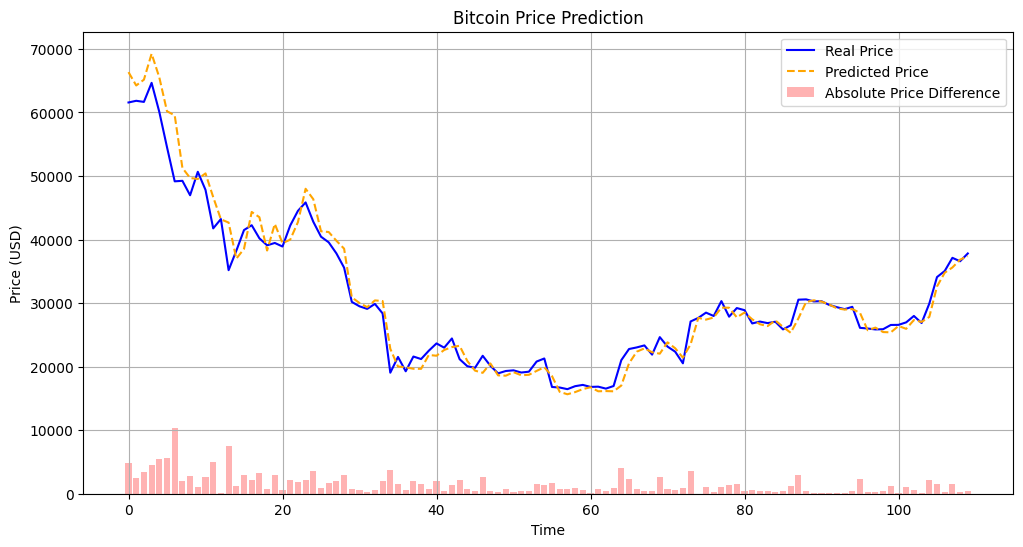

In [18]:
evaluate.plot()

Using now a rolling window to predict the price from the date 0 to the last date, by moving the window by one day at each iteration.

**Problem Definition:**
We have a time series of price data, denoted as $P = \{p_0, p_1, p_2, ..., p_{n-1}, p_n\} $, where $p_i$ represents the price at time step *i*, and *n* represents the total number of time steps.

We want to use a rolling window of size *w* to predict the price at each time step *t*, denoted as $\hat{p}_t$, using the price data within the window.

Let's denote the rolling window as $W_t$, which contains the price data from time step $t-w$ to time step $t-1$. Then, the rolling window at time step $t$ is defined as:

$ W_t = \{p_{t-w}, p_{t-w+1}, ..., p_{t-1}\} $

Now, we need to define a prediction function $f$ that takes the price data within the rolling window $W_t$ as input and predicts the price $\hat{p}_t$ at time step $t$. This prediction function can be any regression model, such as linear regression, neural network, etc. We can represent this function as:

$\hat{p}_t = f(W_t)$

Finally, we iterate over each time step $t$ from 0 to $n-w$ (since we need at least $w$ time steps of historical data to form a complete rolling window), and apply the prediction function $f$ to obtain the predicted price $\hat{p}_t$ for each time step.

In summary, the mathematical formula for predicting the price using a rolling window can be expressed as:

$$\hat{p}_t = f(W_t), \text{ where } W_t = \{p_{t-w}, p_{t-w+1}, ..., p_{t-1}\}$$

In [101]:
etl_test_length = etl.test.shape[0]
timestep = 6
real, pr = [], []

for i in range(0, etl_test_length - timestep):
    start = i
    end = start + timestep

    x = etl.test[start:end, :]
    x = x.reshape(1, timestep, 1)
    
    predicted_price = model.predict(x).flatten()[0]
    real_price = etl.test[end, 0]
    
    pr.append(predicted_price)
    real.append(etl.test[end, 0])

1/1 [==============================] - 0s 28ms/step
[0.9024748779444857]


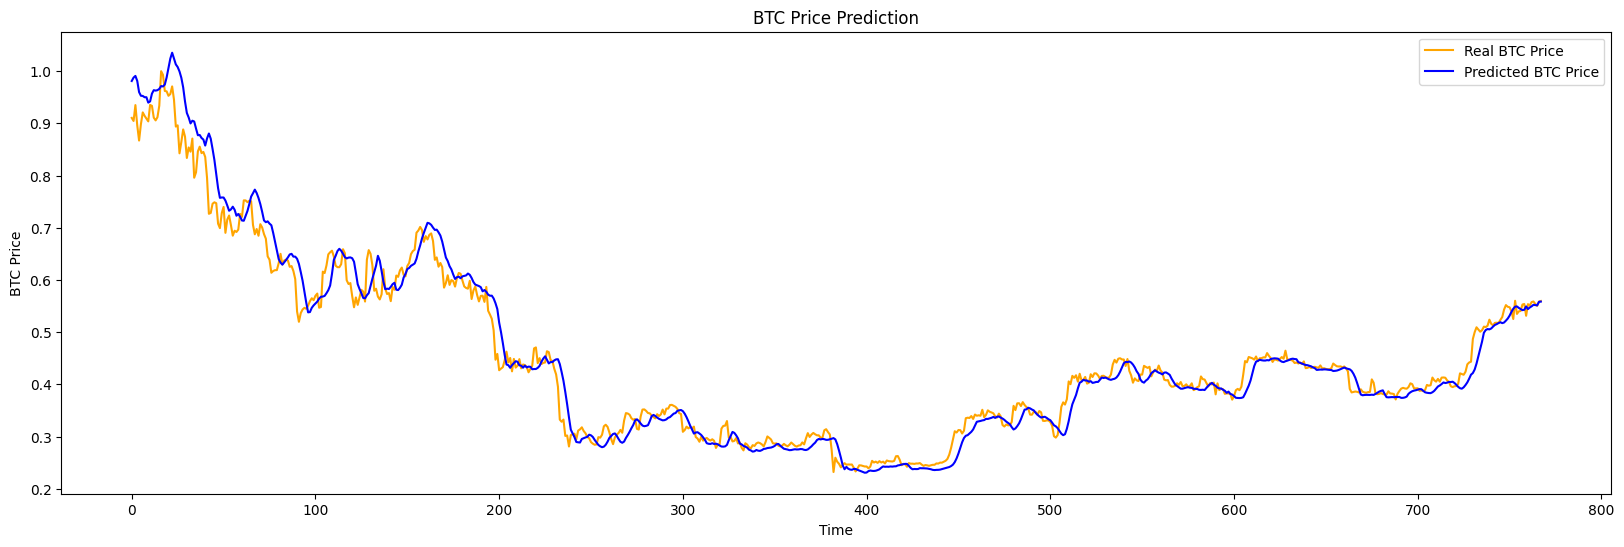

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(real, color='orange', label='Real BTC Price')
plt.plot(pr, color='blue', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [25]:
test.shape

(6, 1)

In [28]:
etl.test_x.shape

(110, 6, 1)

In [29]:
res = model.predict(test.reshape(1, 6, 1))
etl.inverse_scale(res)

1/1 [==============================] - 0s 18ms/step


array([66347.71316432])